<img src="https://upload.wikimedia.org/wikipedia/commons/8/89/TheNorthFace_logo.svg" alt="THE NORTH FACE LOGO" width="50%" />

# The North Face e-commerce : boosting online sales !

## Company's Description 📇

The North Face is an American outdoor recreation product company, founded in 1968 to supply climbers. The North Face produces clothing, footwear, and outdoor equipment. By the late 1990s customers had expanded beyond outdoor enthusiasts and in the 2000s it became a fashion style symbol.

## Project 🚧

The marketing department would like to take advantage of machine learning solutions to boost online sales on the website : https://www.thenorthface.fr/

They have identified two major solutions that could have a huge effect on the conversion rates :
- Deploying a **recommender system** that will allow to suggest additionnal products to users, that are similar to the items they are already interested in. The recommendations could be materialized by a "you might also be interested by these products..." section that would appear on each product page of the website.
- Improving the structure of the products catalog thanks to **topic extraction**. The idea is to use unsupervised methods to challenge the existing categories : is it possible to find new categories of product that would be more suitable for the navigation on the website ? 


## Goals 🎯

The project can be cut into three steps :

1. Identify groups of products that have similar descriptions.

2. Use the groups of similar products to build a simple recommender system algorithm.

3. Use topic modeling algorithms to automatically assess the latent topics present in the item descriptions.

In [1]:
# Libraries to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import en_core_web_sm

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import DBSCAN

import wordcloud

from sklearn.decomposition import TruncatedSVD


In [3]:
# Data 
data = pd.read_csv('sample_data.csv')
print('Number of articles (or documents) :', data.shape[0])
data.head()

Number of articles (or documents) : 500


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


### This dataset is a 500 articles repertories sold by The North Face. It contains two columns where the first is the ID of each article and the second is the description of each article. 


### Let's separate product's title from the description of article

In [4]:
# Create new column that contains only the product's title.
data['product_title'] = data['description'].apply(lambda x: x.split(' - ', 1)[0])
data['description'] = data['description'].apply(lambda x: x.split(' - ', 1)[1])

new_cols = ['id', 'product_title', 'description']
data=data.reindex(columns=new_cols)
data.head()

,id,product_title,description
0,1,Active classic boxers,There's a reason why our boxers are a cult fav...
1,2,Active sport boxer briefs,Skinning up Glory requires enough movement wit...
2,3,Active sport briefs,These superbreathable no-fly briefs are the mi...
3,4,Alpine guide pants,"Skin in, climb ice, switch to rock, traverse a..."
4,5,Alpine wind jkt,"On high ridges, steep ice and anything alpine,..."


In [5]:
# Let look the description of the first article
data['description'][0]

'There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><br>Made in Mexico.'

### Let's remove all non alphanumeric strings and transform all uppercase in lowercase string

In [6]:
data['description'] = data['description'].apply(lambda x: ''.join(i.lower() for i in x if i.isalnum() or i==" "))

# Let look the description of the first article after the first transformation
data['description'][0]

'theres a reason why our boxers are a cult favorite  they keep their cool especially in sticky situations the quickdrying lightweight underwear takes up minimal space in a travel pack an exposed brushed waistband offers nexttoskin softness fivepanel construction with a traditional boxer back for a classic fit and a functional fly made of 37oz 100 recycled polyester with moisturewicking performance inseam size m is 4 12 recyclable through the common threads recycling programbrbrbdetailsbul lisilky capilene 1 fabric is ultralight breathable and quicktodryli liexposed brushed elastic waistband for comfortli li5panel construction with traditional boxer backli liinseam size m is 4 12liulbrbrbfabric b37oz 100 allrecycled polyester with gladiodor natural odor control for the garment recyclable through the common threads recycling programbrbrbweight b99 g 35 ozbrbrmade in mexico'

### Let's take only non digit string

In [7]:
data['description'] = data['description'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

# Let look the description of the first article after the second transformation
data['description'][0]


'theres a reason why our boxers are a cult favorite  they keep their cool especially in sticky situations the quickdrying lightweight underwear takes up minimal space in a travel pack an exposed brushed waistband offers nexttoskin softness fivepanel construction with a traditional boxer back for a classic fit and a functional fly made of oz  recycled polyester with moisturewicking performance inseam size m is   recyclable through the common threads recycling programbrbrbdetailsbul lisilky capilene  fabric is ultralight breathable and quicktodryli liexposed brushed elastic waistband for comfortli lipanel construction with traditional boxer backli liinseam size m is  liulbrbrbfabric boz  allrecycled polyester with gladiodor natural odor control for the garment recyclable through the common threads recycling programbrbrbweight b g  ozbrbrmade in mexico'

### Because we deal with english language, let load `en_core_web_sm` that is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, syntax and entities.

In [8]:
## Let import STOP_WORDS in english language
from spacy.lang.en.stop_words import STOP_WORDS

## Create an object of en_core_web_sm.load()
nlp = en_core_web_sm.load()

# tokenization by words
data['description_tokenized'] = data['description'].apply(lambda x: nlp(x))

# Lemmatization and remove stop-words
data['description_tokenized'] = data['description_tokenized'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
data.head()

,id,product_title,description,description_tokenized
0,1,Active classic boxers,theres a reason why our boxers are a cult favo...,"[s, reason, boxer, cult, favorite, , cool, es..."
1,2,Active sport boxer briefs,skinning up glory requires enough movement wit...,"[skin, glory, require, movement, boxer, decide..."
2,3,Active sport briefs,these superbreathable nofly briefs are the min...,"[superbreathable, nofly, brief, minimalist, ch..."
3,4,Alpine guide pants,skin in climb ice switch to rock traverse a kn...,"[skin, climb, ice, switch, rock, traverse, kni..."
4,5,Alpine wind jkt,on high ridges steep ice and anything alpine t...,"[high, ridge, steep, ice, alpine, jacket, serv..."


### Let create a new column call `nlp_ready` that contains join words from lemmatization without STOP_WORDS

In [9]:
data['nlp_ready'] = data['description_tokenized'].apply(lambda x: ' '.join([word for word in x if len(word) > 1]))
data.head()

,id,product_title,description,description_tokenized,nlp_ready
0,1,Active classic boxers,theres a reason why our boxers are a cult favo...,"[s, reason, boxer, cult, favorite, , cool, es...",reason boxer cult favorite cool especially sti...
1,2,Active sport boxer briefs,skinning up glory requires enough movement wit...,"[skin, glory, require, movement, boxer, decide...",skin glory require movement boxer decide poach...
2,3,Active sport briefs,these superbreathable nofly briefs are the min...,"[superbreathable, nofly, brief, minimalist, ch...",superbreathable nofly brief minimalist choice ...
3,4,Alpine guide pants,skin in climb ice switch to rock traverse a kn...,"[skin, climb, ice, switch, rock, traverse, kni...",skin climb ice switch rock traverse knifeedge ...
4,5,Alpine wind jkt,on high ridges steep ice and anything alpine t...,"[high, ridge, steep, ice, alpine, jacket, serv...",high ridge steep ice alpine jacket serve true ...


### Let vectorized `nlp_ready` column with scikit-learn class call `TfidfVectorizer`

In [26]:
# TF-IDF vector

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['nlp_ready'])

# Dense form of X sparse matrix
dense = X.toarray()
print('Dense shape :', dense.shape)

print()

print('Dense form of X sparse matrix : \n' , dense)

print()

print('Get feature names :', vectorizer.get_feature_names_out())

Dense shape : (500, 5166)

Dense form of X sparse matrix : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Get feature names : ['abandon' 'ability' 'able' ... 'zipthrough' 'zone' 'zonesli']


In [23]:
# DataFrame of dense form of X sparse matrix
dense_X_frame = pd.DataFrame(data = dense, columns=[x for x in vectorizer.get_feature_names_out()], index=["doc_{}".format(x) for x in range(1, dense.shape[0]+1)])
dense_X_frame.head()

,abandon,ability,able,aboveknee,abovetheknee,abrasion,abrasionli,abrasionresistance,abrasionresistant,abrasive,...,zippers,zippersli,zippersliulbrbrbfabric,zippingli,zippocket,zips,zipsecurity,zipthrough,zone,zonesli
doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.114206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
dense_X_frame['ability'].loc[dense_X_frame['ability']!=0.0]

doc_20     0.125248
doc_340    0.118504
doc_430    0.084864
Name: ability, dtype: float64

In [36]:
data.loc[60, :]

id                                                                      61
product_title                                                Cap 3 bottoms
description              like birds and clouds kids stay on the move th...
description_tokenized    [like, bird, cloud, kid, stay, abandon, not, n...
nlp_ready                like bird cloud kid stay abandon not need purp...
Name: 60, dtype: object

### Let use `DBSCAN` to make some clustering on the TF-IDF matrix

In [39]:
db = DBSCAN(eps=0.7, min_samples=6, metric="cosine")
db.fit(X)

# show of unique label with the number of element in the label
uniq_lab = np.unique(db.labels_, return_counts=True)
for i, j in zip(uniq_lab[0], uniq_lab[1]):
    print(f'cluster {i}', '--->', j)

cluster -1 ---> 196
cluster 0 ---> 17
cluster 1 ---> 10
cluster 2 ---> 52
cluster 3 ---> 40
cluster 4 ---> 56
cluster 5 ---> 27
cluster 6 ---> 8
cluster 7 ---> 8
cluster 8 ---> 22
cluster 9 ---> 6
cluster 10 ---> 24
cluster 11 ---> 6
cluster 12 ---> 7
cluster 13 ---> 8
cluster 14 ---> 6
cluster 15 ---> 7


In [43]:
# Add a new column call 'cluster' that give the the cluster number of each document
dense_X_frame['cluster'] = db.labels_
dense_X_frame.head(10)

,abandon,ability,able,aboveknee,abovetheknee,abrasion,abrasionli,abrasionresistance,abrasionresistant,abrasive,...,zippersli,zippersliulbrbrbfabric,zippingli,zippocket,zips,zipsecurity,zipthrough,zone,zonesli,cluster
doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
doc_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
doc_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
doc_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
doc_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
doc_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
doc_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


### Let create a function that take in argument the dataframe of dense TD-IDF matrix and a cluster number and return a list of the most important words in each document of the same cluster

In [49]:
def list_world_cluster(df, n_label):
    '''
    This function create a list of the most important words
    in each document of a same given cluster 

    arguments:

    df : dataframe of dense TD-IDF matrix
    n_cluster : a given cluster number 
    
    '''

    # Select lines of a given cluster number
    mask =  df['cluster']==n_label
    
    # idxs will contain all documents of the given cluster number
    idxs = df.loc[mask, :].index

    # This empty list will recieve the most important word of each document present in idxs
    words_cluster = []
    
    
    for id in idxs:
        # idx contains all words that represent features of our dataframe df
        idx = list(df.loc[mask, :].loc[id, :].index)
        
        # idx contains all values of TD-IDF for a given document in idxs
        val = df.loc[mask, :].loc[id, :].values

        # In order to select the feature (word) with a maximum value of TD-IDF,
        # let remove 'cluster' feature that is not a name of the corpus
        idx.remove('cluster')
        val = val[:-1]
        
        # For each document of a given cluster number, we select and add to 'words_cluster' 
        # the most important word (or feature)
        words_cluster.append(idx[np.argmax(val)])

    # We return list 'words_cluster' as a str type
    return ' '.join(words_cluster)

n_c = 15
print(f'The most important words of all documents prensent in the cluster {n_c} are : ', list_world_cluster(dense_X_frame, 1))

The most important words of all documents prensent in the cluster 15 are :  coverage scoop coverage sewnin bayonne straight straight coverage straight scoop


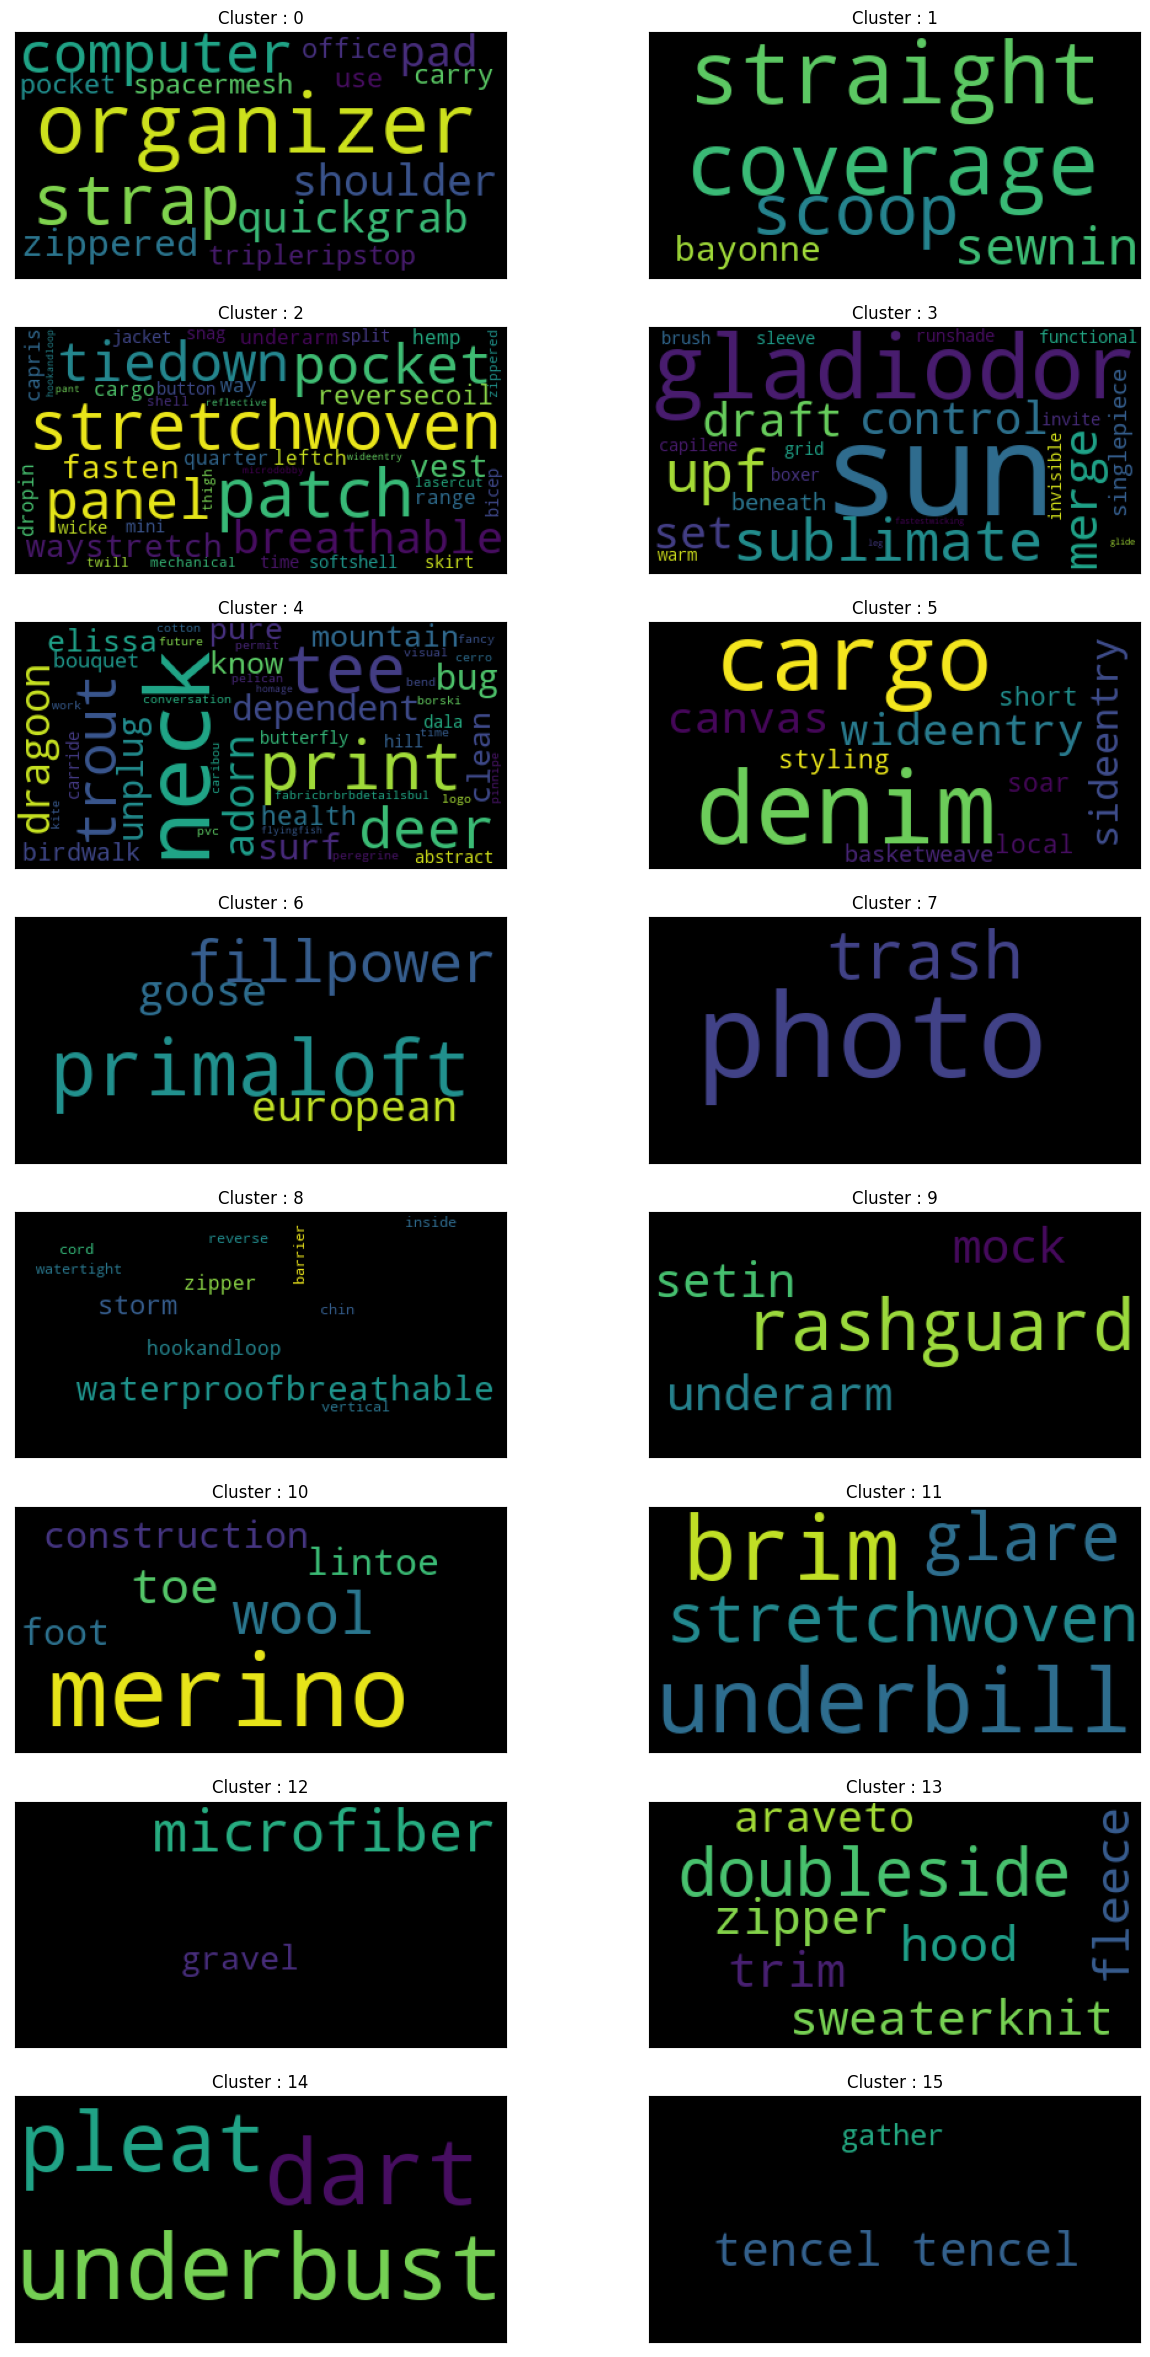

In [51]:
# Let display a wordcloud of each cluster

wd = wordcloud.WordCloud(stopwords=STOP_WORDS)

labels = np.unique(db.labels_)[1:]

s = int(len(labels)/2)
if len(labels)%2!=0:
    s = int(len(labels)/2)+1

fig, ax = plt.subplots(nrows=s, ncols=2, figsize=(15,30), subplot_kw=dict(xticks=[], yticks=[]))

for i, axi in enumerate(ax.flat):

    world_cluster = list_world_cluster(dense_X_frame, labels[i])
    cloud = wd.generate(world_cluster)
    axi.imshow(cloud)
    axi.set_title(f'Cluster : {labels[i]}', size=12)

### Let create a function named `find_similar_items` that takes an argument `item_id` representing the id of a product, and that returns a list of 5 item ids that belong to the same cluster as the product passed in argument

In [60]:
def find_similar_items(item_id):
    '''
    This function suggests to a user some products that are similar to the ones he is interested in.
    It creates a list of 5 documents present in the same cluster as the one the user has selected.
    
    arguments:

    item_id : id of the product the user has selected

    '''
    
    # title of the product selected
    product_select = data['product_title'][item_id]

    # Cluster number of the product selected
    label_product = dense_X_frame['cluster'][item_id]

    # Select all product that have the same cluster number as the product selected
    mask =  dense_X_frame['cluster'] == label_product

    # idxs will contain all similar product 
    idxs = dense_X_frame.loc[mask, :].index

    # Because idxs are list of strings (ex ['doc_2', 'doc_3', 'doc_6', 'doc_9', 'doc_10']), 
    # In order to select similar product in 'product_title' of data dataframe where id are integer 
    # We need to remove 'doc_' and cast str number into ingeter
    idxs = [int(i[4:]) for i in idxs]

    recommended_list = list(data['product_title'].loc[idxs[0:5]].values)

    return f'Because you choose the product : {product_select}, you can be interested by these products : {recommended_list}'


find_similar_items(int(input('Please select a product id')))

"Because you choose the product : Active classic boxers, you can be interested by these products : ['Active sport boxer briefs', 'Cap 1 boxer briefs', 'Cap 1 graphic t-shirt', 'Cap 1 t-shirt', 'Cap 2 t-shirt']"

### Now let use an LSA model to automatically extract latent topics in the products' descriptions.

### Let use TruncatedSVD to make some topic extraction from the TF-IDF matrix. We will use 20 `n_components` 

In [62]:
svd_model = TruncatedSVD(n_components=20,  random_state=122)

lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_{}".format(i) for i in range(0,20)])

topic_encoded_df["documents"] = data['nlp_ready']

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,documents
0,0.257080,-0.073121,0.145771,0.118146,-0.114507,-0.008268,-0.036474,-0.048117,0.045309,-0.124891,...,0.051565,0.036600,-0.018547,0.033426,0.001982,0.020821,0.076930,0.085002,-0.001768,reason boxer cult favorite cool especially sti...
1,0.240140,-0.074506,0.060201,0.095056,-0.021961,0.044773,0.003475,0.001671,0.007295,-0.063219,...,0.056932,0.162889,0.040380,-0.046319,-0.002447,0.008892,-0.026179,0.184883,0.040163,skin glory require movement boxer decide poach...
2,0.211974,-0.067869,0.062225,0.042360,-0.037259,0.046051,0.040233,0.063804,0.004592,-0.023030,...,-0.027600,0.165353,0.066663,-0.060447,0.028723,0.000920,-0.005210,0.126250,0.031850,superbreathable nofly brief minimalist choice ...
3,0.299204,-0.214102,-0.106493,-0.100970,0.011630,-0.034920,-0.045652,-0.038549,-0.004080,-0.023307,...,0.094331,0.058642,-0.068081,-0.020410,-0.007844,0.079776,0.173817,-0.091723,-0.033878,skin climb ice switch rock traverse knifeedge ...
4,0.326885,-0.277361,-0.036436,-0.187424,-0.068760,-0.077602,0.007333,0.050211,-0.002075,0.032807,...,0.066325,0.082267,-0.159347,0.106946,0.176430,-0.025838,-0.110607,0.009258,0.085103,high ridge steep ice alpine jacket serve true ...


### Let create a new column call `predict_topic` that give the most relevant topic of each document.

In [65]:

topic_encoded_df['predict_topic'] = [np.argmax(i) for i in lsa]
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,documents,predict_topic
0,0.257080,-0.073121,0.145771,0.118146,-0.114507,-0.008268,-0.036474,-0.048117,0.045309,-0.124891,...,0.036600,-0.018547,0.033426,0.001982,0.020821,0.076930,0.085002,-0.001768,reason boxer cult favorite cool especially sti...,0
1,0.240140,-0.074506,0.060201,0.095056,-0.021961,0.044773,0.003475,0.001671,0.007295,-0.063219,...,0.162889,0.040380,-0.046319,-0.002447,0.008892,-0.026179,0.184883,0.040163,skin glory require movement boxer decide poach...,0
2,0.211974,-0.067869,0.062225,0.042360,-0.037259,0.046051,0.040233,0.063804,0.004592,-0.023030,...,0.165353,0.066663,-0.060447,0.028723,0.000920,-0.005210,0.126250,0.031850,superbreathable nofly brief minimalist choice ...,0
3,0.299204,-0.214102,-0.106493,-0.100970,0.011630,-0.034920,-0.045652,-0.038549,-0.004080,-0.023307,...,0.058642,-0.068081,-0.020410,-0.007844,0.079776,0.173817,-0.091723,-0.033878,skin climb ice switch rock traverse knifeedge ...,0
4,0.326885,-0.277361,-0.036436,-0.187424,-0.068760,-0.077602,0.007333,0.050211,-0.002075,0.032807,...,0.082267,-0.159347,0.106946,0.176430,-0.025838,-0.110607,0.009258,0.085103,high ridge steep ice alpine jacket serve true ...,0


In [70]:
import plotly.express as px
print(topic_encoded_df['predict_topic'].value_counts())
px.histogram(topic_encoded_df['predict_topic'])



0     255
1      50
2      39
7      29
5      24
13     16
9      16
15     10
3       9
18      9
19      8
8       8
10      8
11      6
16      6
4       5
12      1
6       1
Name: predict_topic, dtype: int64


### We can see the `topic 0` is the topic that represent the most documents by far.

### But how is construct the topic vectors? 
### We know they are linear combination of word vectors contained in all documents

In [72]:
# By taking the transpose matrix of svd_model.components_ we can get this linear combination 
topic_comb_df = pd.DataFrame(svd_model.components_.T, columns = ["topic_{}".format(i) for i in range(0,20)], index=vectorizer.get_feature_names_out())
topic_comb_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
abandon,0.001193,-0.000837,0.003220,0.001285,-0.004119,-0.000730,-0.000435,-0.002102,0.001269,-0.004625,0.000245,0.001638,-0.000244,-0.000554,0.001108,-0.001904,-0.001697,0.004425,0.001030,0.001205
ability,0.002544,-0.002066,0.005850,0.001659,-0.010519,0.004870,-0.004010,-0.001861,-0.001260,0.006254,0.010511,-0.003406,-0.008528,-0.002554,0.002178,-0.004764,-0.000576,0.009681,0.000043,0.001211
able,0.000345,-0.000395,-0.000018,-0.000238,0.000835,0.001863,-0.000037,0.000460,0.000369,-0.000861,0.001039,0.000523,-0.000063,0.000289,-0.001236,-0.000985,-0.000912,-0.001150,-0.001290,0.001374
aboveknee,0.000648,-0.000687,-0.000815,-0.000277,0.000492,0.001510,0.000287,0.000092,0.000150,-0.001363,-0.000535,0.000690,0.001786,-0.000864,-0.001253,-0.003206,-0.000277,0.000157,-0.000038,0.003442
abovetheknee,0.000713,0.000096,-0.000386,0.001846,0.000335,0.000078,0.002651,0.001389,0.000364,-0.000814,-0.000181,-0.000225,0.003491,-0.004888,-0.004991,-0.006645,-0.000680,0.003152,-0.003069,0.001895


In [73]:
# Let take all word vectors
feature_names = vectorizer.get_feature_names_out()

# Let create a function that return top 20 of most important word vectors of a given topic
def feature_topic(svd, f_n, topic):
    return ' '.join([f_n[i] for i in svd.components_[topic].argsort()[::-1]][:20])

feature_topic(svd_model, feature_names, 0)

'recycle organic cotton recyclable common thread pocket polyester shoulder soft pvc ink durable fabric nylon dwr programbrbrbweight water programbrbrbdetailsbul boz'

### Let create a `WordCloud` of the top 20 most important word vectors of each topic

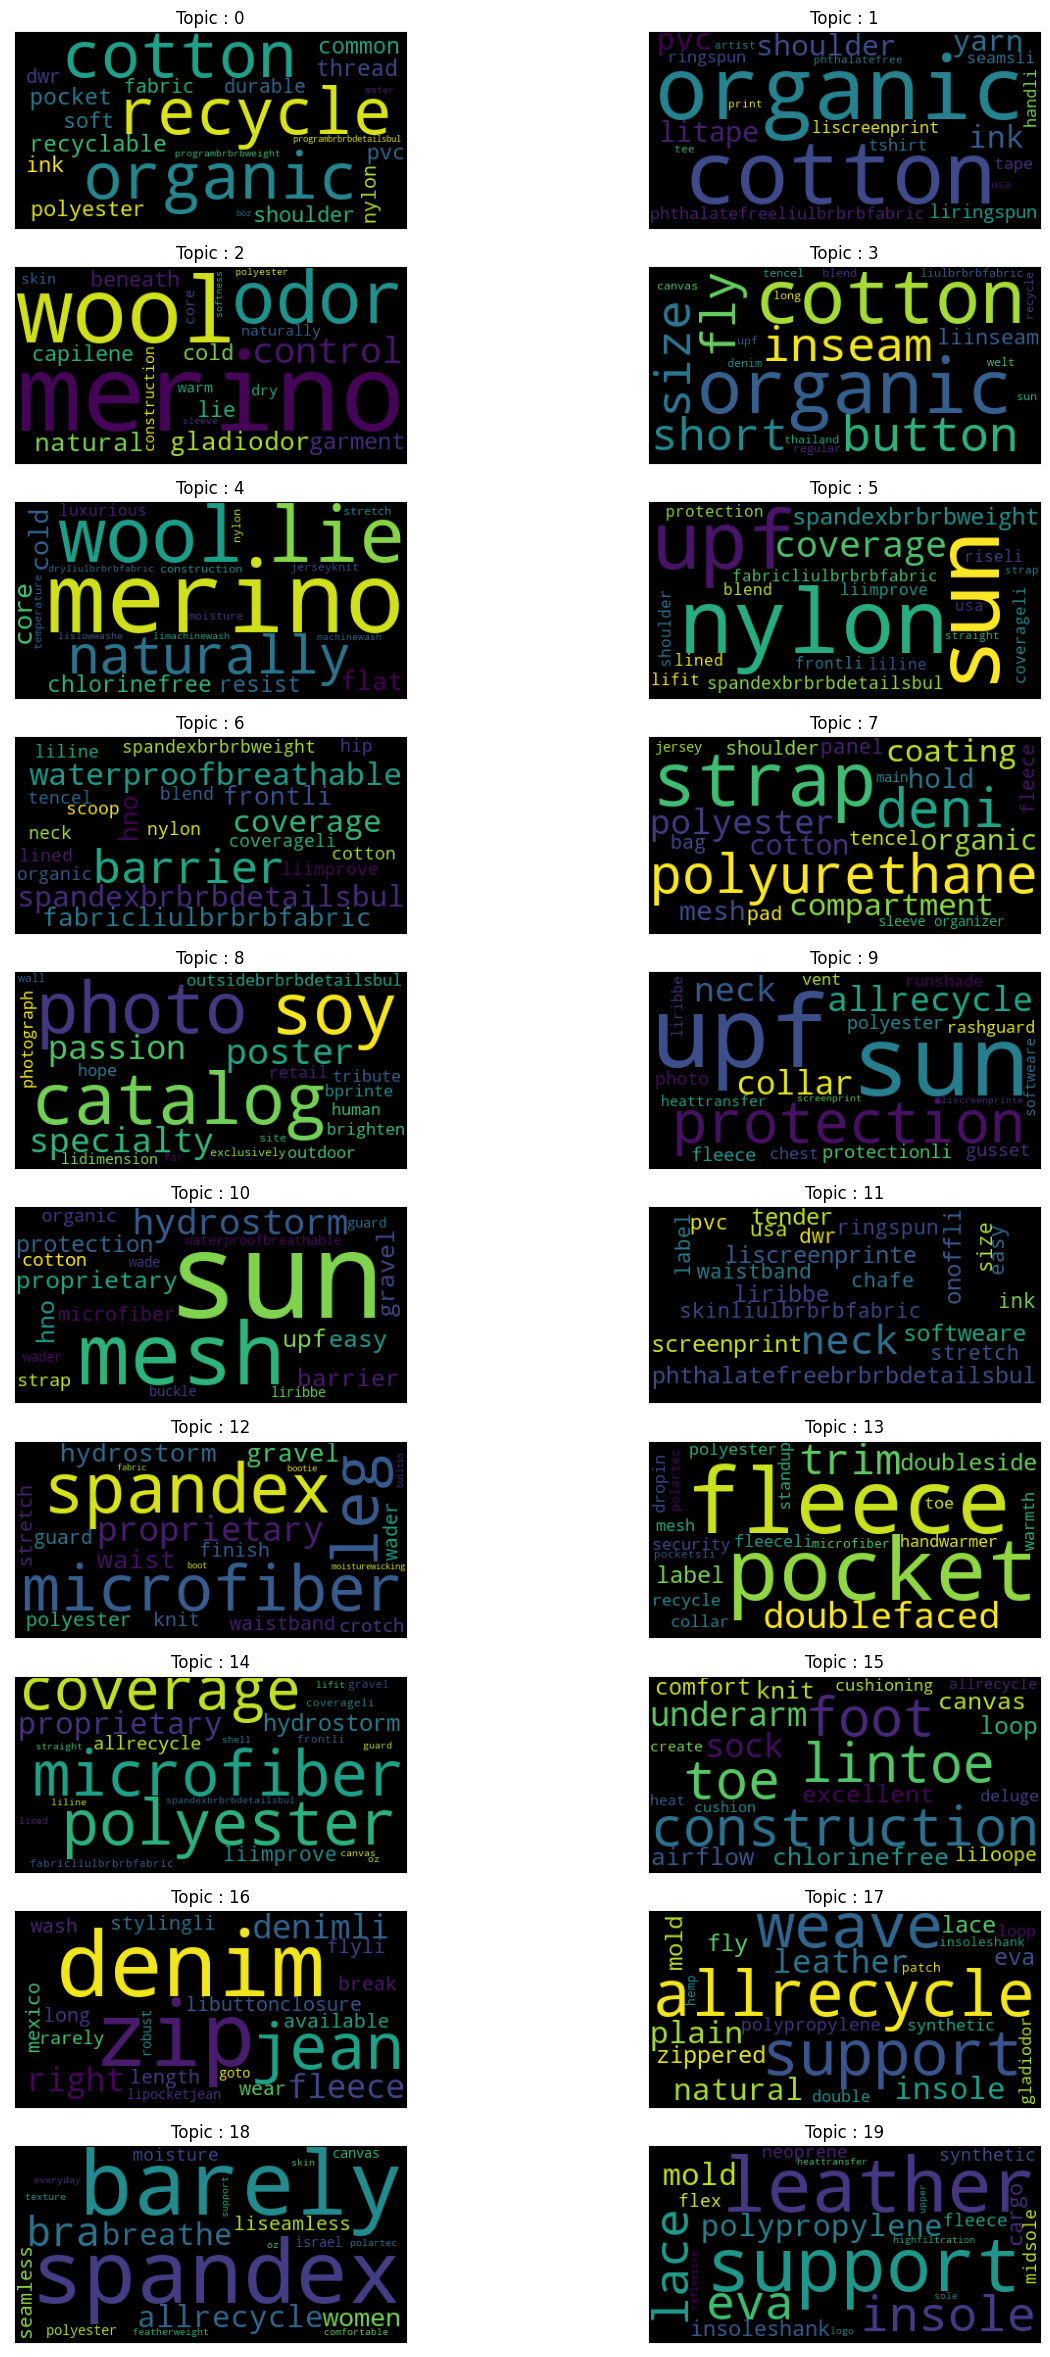

In [74]:
wd = wordcloud.WordCloud()


fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,30), subplot_kw=dict(xticks=[], yticks=[]))

for i, axi in enumerate(ax.flat):

    world_cluster = feature_topic(svd_model, feature_names, i)
    cloud = wd.generate(world_cluster)
    axi.imshow(cloud)
    axi.set_title(f'Topic : {i}', size=12)